In [1]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from collections import Counter

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Read input files

In [2]:
test = pd.read_csv('DATA_SCIENCE_PROJECT/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('DATA_SCIENCE_PROJECT/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('DATA_SCIENCE_PROJECT/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('DATA_SCIENCE_PROJECT/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('DATA_SCIENCE_PROJECT/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

### Join data and print

In [3]:
train = sales.join(items, on='item_id', rsuffix='_')\
.join(shops, on='shop_id', rsuffix='_')\
.join(item_categories, on='item_category_id', rsuffix='_')\
.drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [4]:
print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

display(train.head())
display(train.describe())

Train rows: 2935849
Train columns: 10


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### Preprocessing

In [5]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]

# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

In [6]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

display(train_monthly.head(10))
display(train_monthly.describe().T)

,date_block_num,shop_id,item_id,item_cnt,item_cnt_month
0,0,2,33,1,2.00
1,0,2,482,1,1.00
2,0,2,491,1,1.00
3,0,2,839,1,1.00
4,0,2,1007,3,1.00
5,0,2,1010,1,1.00
6,0,2,1023,2,1.00
7,0,2,1204,1,nan
8,0,2,1224,1,nan
9,0,2,1247,1,nan


,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.00,20.18,9.14,0.00,13.00,22.00,28.00,33.00
shop_id,593829.00,32.07,16.90,2.00,19.00,31.00,47.00,59.00
item_id,593829.00,10015.02,6181.82,30.00,4418.00,9171.00,15334.00,22167.00
item_cnt,593829.00,2.10,2.31,0.00,1.00,1.00,2.00,20.00
item_cnt_month,482536.00,2.07,2.17,0.00,1.00,1.00,2.00,20.00


In [7]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


In [9]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

In [10]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [11]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0,0,0,0,0,0,0,0,0,0,0,0
45150,0,0,0,0,0,0,0,0,0,0,0,0
143433,0,0,4,2,1,2,2,1,0,0,0,1
202144,0,0,0,0,0,0,0,0,0,0,0,0
136088,0,0,0,0,0,0,0,1,0,0,1,0


In [12]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


### Modelling

### LSTM Model

In [13]:

serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(L.LSTM(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 6)             408       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 32        
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
______________________________________________________

In [14]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 39s - loss: 1.5067 - val_loss: 1.3122
Epoch 2/20
1566/1566 - 23s - loss: 1.3280 - val_loss: 1.2557
Epoch 3/20
1566/1566 - 26s - loss: 1.2744 - val_loss: 1.2236
Epoch 4/20
1566/1566 - 25s - loss: 1.2339 - val_loss: 1.1950
Epoch 5/20
1566/1566 - 27s - loss: 1.2026 - val_loss: 1.1723
Epoch 6/20
1566/1566 - 23s - loss: 1.1754 - val_loss: 1.1573
Epoch 7/20
1566/1566 - 23s - loss: 1.1700 - val_loss: 1.1529
Epoch 8/20
1566/1566 - 23s - loss: 1.1677 - val_loss: 1.1511
Epoch 9/20
1566/1566 - 23s - loss: 1.1664 - val_loss: 1.1484
Epoch 10/20
1566/1566 - 23s - loss: 1.1652 - val_loss: 1.1484
Epoch 11/20
1566/1566 - 23s - loss: 1.1642 - val_loss: 1.1489
Epoch 12/20
1566/1566 - 22s - loss: 1.1637 - val_loss: 1.1464
Epoch 13/20
1566/1566 - 35s - loss: 1.1629 - val_loss: 1.1453
Epoch 14/20
1566/1566 - 24s - loss: 1.1624 - val_loss: 1.1446
Epoch 15/20
1566/1566 - 24s - loss: 1.1616 - val_loss: 1.1444
Epoch 16/20
1566/1566 - 22s - loss: 1.1616 - val_loss: 1.1459
Epoch 17/20
1566/

### LSTM with attention layer

In [15]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [16]:
lstm_attn_model = Sequential()
lstm_attn_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_attn_model.add(attention(return_sequences=True)) # receive 3D and output 3D
lstm_attn_model.add(L.LSTM(6, activation='relu', return_sequences=True))
lstm_attn_model.add(L.LSTM(1, activation='relu'))
lstm_attn_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_attn_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_attn_model.add(L.Dense(1))
lstm_attn_model.summary()

adam = optimizers.Adam(lr)
lstm_attn_model.compile(loss='mse', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 10)            480       
_________________________________________________________________
attention (attention)        (None, 12, 10)            22        
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 6)             408       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [17]:
lstm_attn_history = lstm_attn_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 31s - loss: 1.5918 - val_loss: 1.3731
Epoch 2/20
1566/1566 - 31s - loss: 1.3911 - val_loss: 1.2993
Epoch 3/20
1566/1566 - 24s - loss: 1.3275 - val_loss: 1.2623
Epoch 4/20
1566/1566 - 24s - loss: 1.2826 - val_loss: 1.2309
Epoch 5/20
1566/1566 - 34s - loss: 1.2457 - val_loss: 1.2139
Epoch 6/20
1566/1566 - 23s - loss: 1.2148 - val_loss: 1.1805
Epoch 7/20
1566/1566 - 23s - loss: 1.1929 - val_loss: 1.1664
Epoch 8/20
1566/1566 - 23s - loss: 1.1792 - val_loss: 1.1708
Epoch 9/20
1566/1566 - 23s - loss: 1.1727 - val_loss: 1.1501
Epoch 10/20
1566/1566 - 22s - loss: 1.1691 - val_loss: 1.1473
Epoch 11/20
1566/1566 - 23s - loss: 1.1676 - val_loss: 1.1459
Epoch 12/20
1566/1566 - 23s - loss: 1.1665 - val_loss: 1.1446
Epoch 13/20
1566/1566 - 23s - loss: 1.1656 - val_loss: 1.1438
Epoch 14/20
1566/1566 - 23s - loss: 1.1649 - val_loss: 1.1439
Epoch 15/20
1566/1566 - 23s - loss: 1.1640 - val_loss: 1.1537
Epoch 16/20
1566/1566 - 22s - loss: 1.1643 - val_loss: 1.1465
Epoch 17/20
1566/

### GRU Model

In [18]:
gru_model = Sequential()
gru_model.add(L.GRU(10, input_shape=(serie_size, n_features), return_sequences=True))
gru_model.add(L.GRU(6, activation='relu', return_sequences=True))
gru_model.add(L.GRU(1, activation='relu'))
gru_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
gru_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
gru_model.add(L.Dense(1))
gru_model.summary()

adam = optimizers.Adam(lr)
gru_model.compile(loss='mse', optimizer=adam)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 12, 10)            390       
_________________________________________________________________
gru_1 (GRU)                  (None, 12, 6)             324       
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 27        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 882
Trainable params: 882
Non-trainable params: 0
________________________________________________________

In [19]:
gru_model_history = gru_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 29s - loss: 1.6880 - val_loss: 1.5153
Epoch 2/20
1566/1566 - 35s - loss: 1.5814 - val_loss: 1.4707
Epoch 3/20
1566/1566 - 38s - loss: 1.3882 - val_loss: 1.2222
Epoch 4/20
1566/1566 - 40s - loss: 1.2325 - val_loss: 1.1996
Epoch 5/20
1566/1566 - 32s - loss: 1.2119 - val_loss: 1.1894
Epoch 6/20
1566/1566 - 28s - loss: 1.1986 - val_loss: 1.1796
Epoch 7/20
1566/1566 - 28s - loss: 1.1892 - val_loss: 1.1727
Epoch 8/20
1566/1566 - 28s - loss: 1.1823 - val_loss: 1.1666
Epoch 9/20
1566/1566 - 28s - loss: 1.1776 - val_loss: 1.1612
Epoch 10/20
1566/1566 - 28s - loss: 1.1744 - val_loss: 1.1574
Epoch 11/20
1566/1566 - 28s - loss: 1.1719 - val_loss: 1.1575
Epoch 12/20
1566/1566 - 28s - loss: 1.1701 - val_loss: 1.1546
Epoch 13/20
1566/1566 - 30s - loss: 1.1688 - val_loss: 1.1524
Epoch 14/20
1566/1566 - 31s - loss: 1.1673 - val_loss: 1.1509
Epoch 15/20
1566/1566 - 41s - loss: 1.1663 - val_loss: 1.1521
Epoch 16/20
1566/1566 - 31s - loss: 1.1654 - val_loss: 1.1508
Epoch 17/20
1566/

### Evaluation

In [20]:
def print_rmse(model):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_valid)
    print('Train rmse:', np.sqrt(mean_squared_error(Y_train, train_pred)))
    print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, val_pred)))


In [21]:
models = [lstm_model, lstm_attn_model, gru_model]

for model in models:
    print_rmse(model)

Train rmse: 1.0764655749243168
Validation rmse: 1.0681918782617401
Train rmse: 1.077348253346555
Validation rmse: 1.068300052383338
Train rmse: 1.0779473906749628
Validation rmse: 1.0706312977691417


In [37]:
pred = lstm_model.predict(X_valid)

In [62]:
len(pred)

22259

In [65]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Sales')
    plt.plot(predicted, color='blue',label='Predicted Sales')
    plt.title('Sales forecasting')
    plt.xlabel('Item id')
    plt.ylabel('Sold Items count')
    plt.legend()
    plt.show()

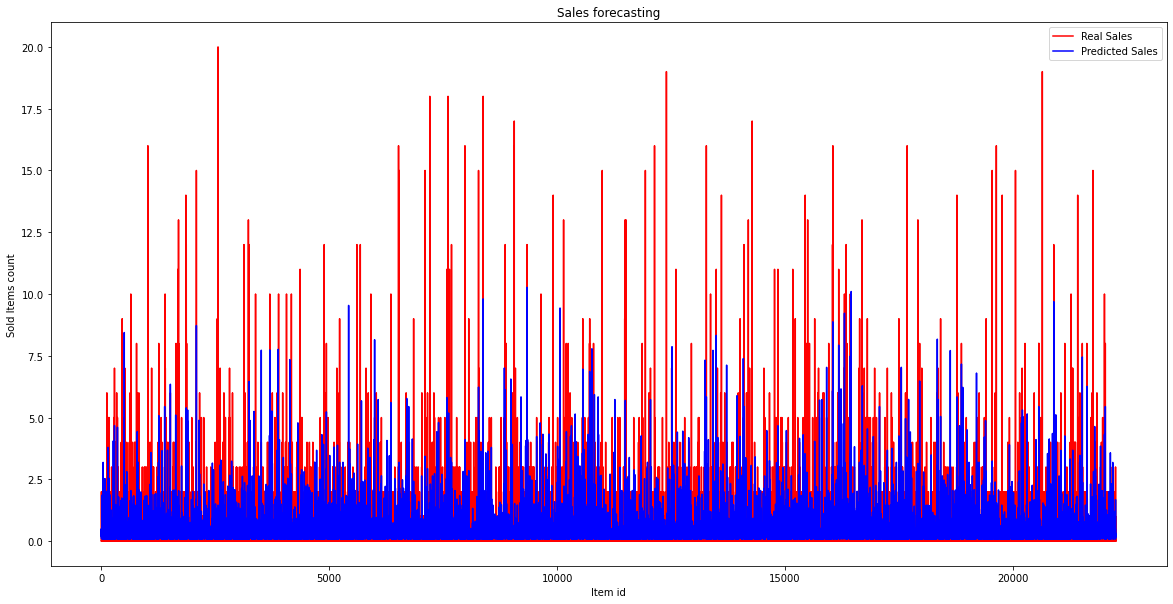

In [66]:
plot_predictions(Y_valid, pred)

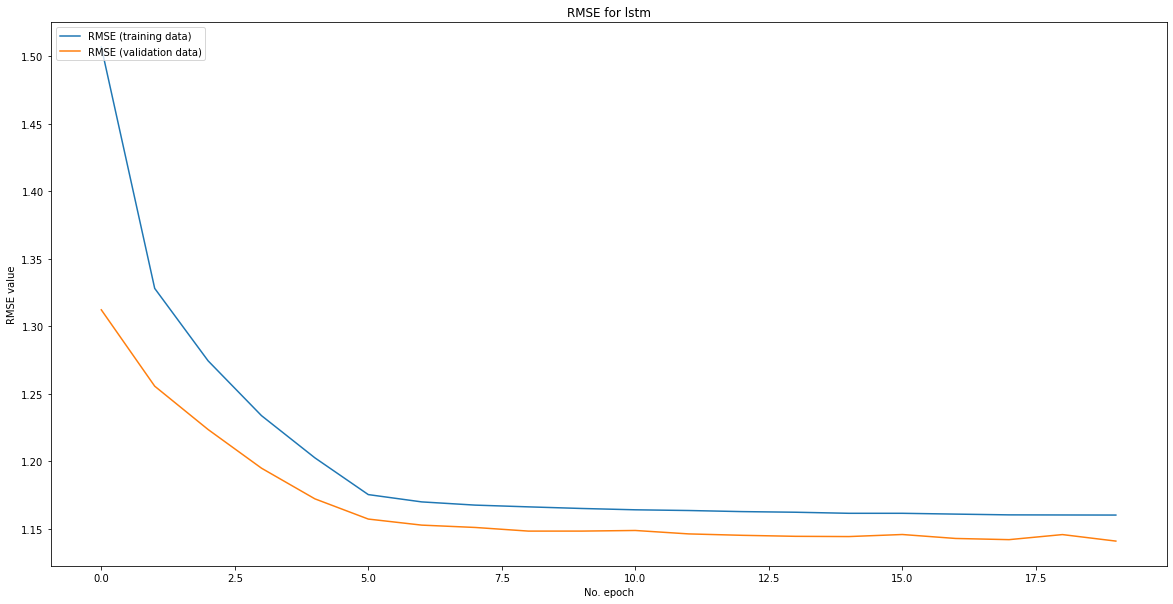

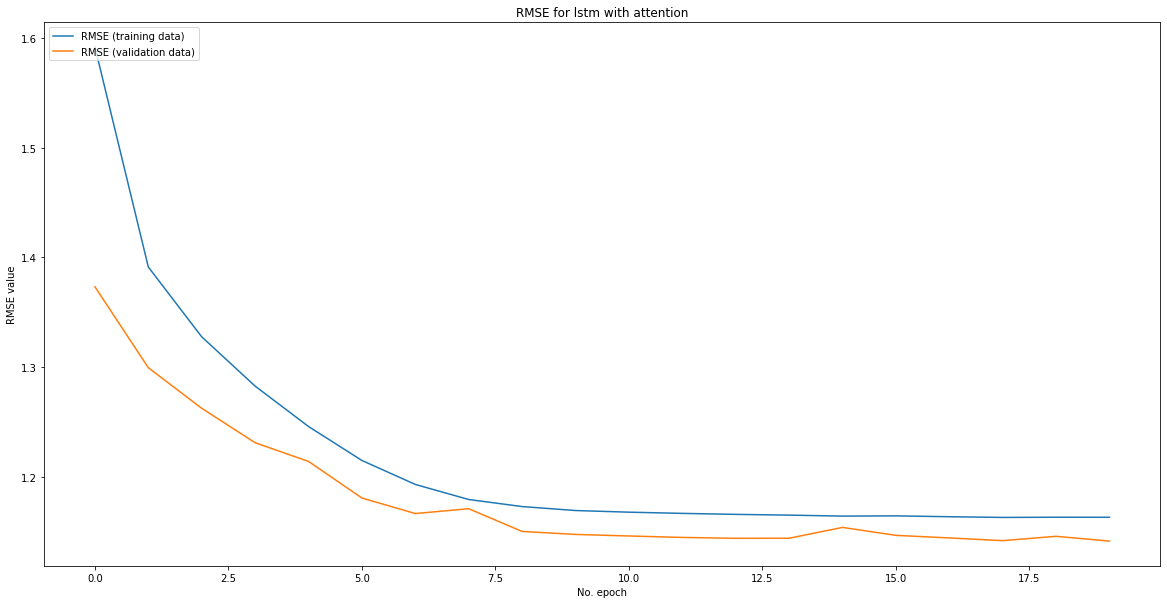

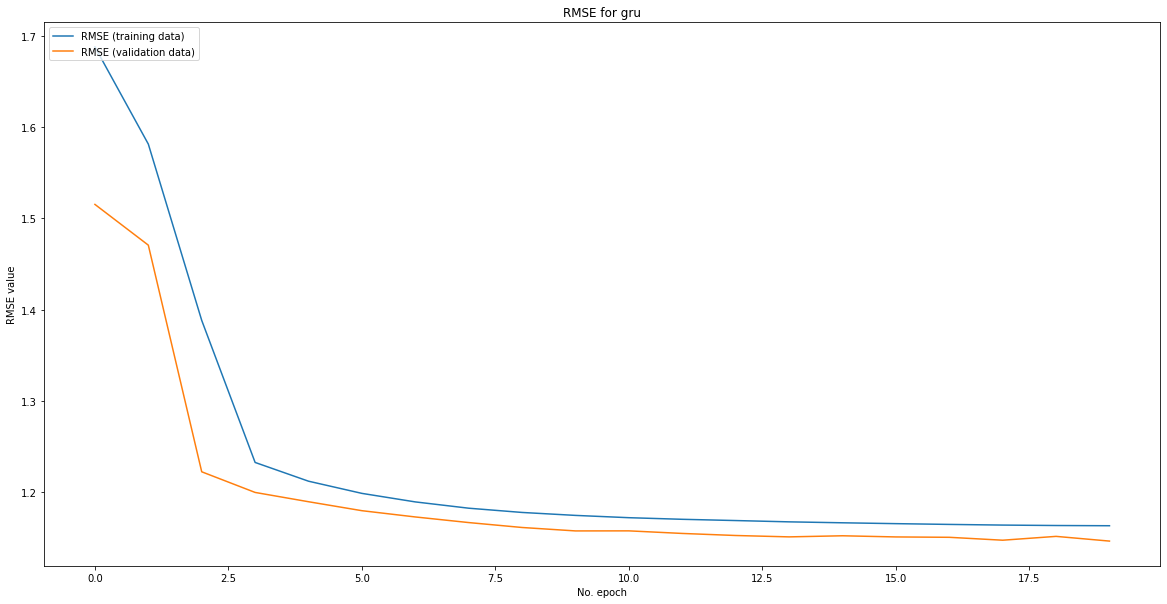

In [71]:
histories = [lstm_history, lstm_attn_history, gru_model_history]
names = ['lstm', 'lstm with attention', 'gru']
# Plot history: MSE

for history,name in zip(histories,names):
    plt.plot(history.history['loss'], label='RMSE (training data)')
    plt.plot(history.history['val_loss'], label='RMSE (validation data)')
    plt.title('RMSE for ' + name)
    plt.ylabel('RMSE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
